In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alirezakay/wider-selected")

print("Path to dataset files:", path)

100%|██████████| 465M/465M [00:22<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alirezakay/wider-selected/versions/2


In [ ]:
!ls /root/.cache/kagglehub/datasets/alirezakay/wider-selected/versions/2


annotations.txt  README.md  train


In [ ]:
!ls /root/.cache/kagglehub/datasets/alirezakay/wider-selected/versions/2/train | head

0--Parade
10--People_Marching
11--Meeting
12--Group
13--Interview
14--Traffic
15--Stock_Market
16--Award_Ceremony
17--Ceremony
18--Concerts


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

RED PNET

In [1]:
#MONTAR EN DRIVE
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/VisionComputacional/WIDER_SELECTED
!cp -r /root/.cache/kagglehub/datasets/alirezakay/wider-selected/versions/2/* \
      /content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/


Requerimiento

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving requirements.txt to requirements.txt


In [ ]:
#Asegúrate de haber montado Drive antes
import shutil

src = "/content/requirements.txt"
dst = "/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/requirements.txt"

shutil.move(src, dst)
print("Archivo movido correctamente a WIDER_SELECTED")


Archivo movido correctamente a WIDER_SELECTED


In [2]:
!pip install -r /content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.0 MB/s eta 0:00:00


entrenamiento P-Net paralelo train_pnet_parallel.py
“El entrenamiento de la P-Net replica el esquema original de MTCNN y utiliza paralelización a nivel de carga de datos mediante tf.data, usando num_parallel_calls=AUTOTUNE y prefetch, permitiendo que la CPU prepare imágenes mientras la GPU ejecuta el forward y backward pass.”

In [3]:
!pip install mtcnn


In [6]:
import os
from pathlib import Path
import tensorflow as tf
import numpy as np
import time

# =========================
# CONFIGURACIÓN
# =========================
DATASET_ROOT = Path("/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/train")
ANNOTATIONS_FILE = Path("/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/annotations.txt")

CHECKPOINT_DIR = Path("/content/drive/MyDrive/VisionComputacional/checkpoints_pnet_con_p")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

print("GPUs disponibles:", tf.config.list_physical_devices("GPU"))

# =========================
# CARGA DE ANOTACIONES (WIDER)
# =========================
def load_wider_annotations(txt_path):
    annotations = {}

    with open(txt_path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        img_name = lines[i].strip()
        i += 1

        num_boxes = int(lines[i].strip())
        i += 1

        boxes = []
        for _ in range(num_boxes):
            parts = lines[i].strip().split()
            x, y, w, h = map(float, parts[:4])
            boxes.append([x, y, w, h])
            i += 1

        if boxes:
            boxes = sorted(boxes, key=lambda b: b[2] * b[3], reverse=True)
            annotations[img_name] = np.array(boxes[0], dtype=np.float32)

    return annotations


annotations = load_wider_annotations(ANNOTATIONS_FILE)
print("Imágenes con anotación:", len(annotations))

# =========================
# DATASET PARALELO
# =========================
def load_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)

    h = tf.shape(img)[0]
    w = tf.shape(img)[1]

    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resized = tf.cast(img_resized, tf.float32) / 255.0

    # ruta relativa para buscar anotación
    rel_path = os.path.relpath(path.numpy().decode(), DATASET_ROOT)
    bbox = annotations[rel_path]   # [x, y, w, h] en imagen ORIGINAL

    # normalización CORRECTA
    bbox_norm = tf.stack([
        bbox[0] / tf.cast(w, tf.float32),
        bbox[1] / tf.cast(h, tf.float32),
        bbox[2] / tf.cast(w, tf.float32),
        bbox[3] / tf.cast(h, tf.float32),
    ])

    cls_label = tf.ones((1,), dtype=tf.float32)

    return img_resized, cls_label, bbox_norm

def pack_labels(img, cls, bbox):
    # cls: (1,)
    # bbox: (4,)

    # replicamos cls y bbox al mapa de salida
    cls_map = tf.ones((59, 59, 1), dtype=tf.float32) * cls
    bbox_map = tf.ones((59, 59, 4), dtype=tf.float32) * bbox

    return img, {
        "cls": cls_map,
        "bbox": bbox_map
    }



def set_shapes(img, y):
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    y["cls"].set_shape((59, 59, 1))
    y["bbox"].set_shape((59, 59, 4))
    return img, y



image_paths = []
for img_name in annotations.keys():
    p = DATASET_ROOT / img_name
    if p.exists():
        image_paths.append(str(p))

print("Imágenes válidas:", len(image_paths))

dataset = (
    tf.data.Dataset.from_tensor_slices(image_paths)
    .shuffle(1000)
    .map(
        lambda p: tf.py_function(
            load_and_preprocess,
            [p],
            (tf.float32, tf.float32, tf.float32)
        ),
        num_parallel_calls=AUTOTUNE
    )
    .map(pack_labels, num_parallel_calls=AUTOTUNE)
    .map(set_shapes, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# =========================
# P-NET (IMPLEMENTACIÓN REAL – PAPER-LIKE)
# =========================
def build_pnet():
    inp = tf.keras.layers.Input(shape=(None, None, 3))

    x = tf.keras.layers.Conv2D(10, 3, padding="valid")(inp)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Conv2D(16, 3, padding="valid")(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    x = tf.keras.layers.Conv2D(32, 3, padding="valid")(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    cls = tf.keras.layers.Conv2D(1, 1, activation="sigmoid", name="cls")(x)
    bbox = tf.keras.layers.Conv2D(4, 1, name="bbox")(x)

    return tf.keras.Model(inp, outputs=[cls, bbox], name="PNet")


model = build_pnet()
model.summary()

# =========================
# COMPILACIÓN (MULTI-TASK – PAPER)
# =========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "cls": "binary_crossentropy",
        "bbox": tf.keras.losses.Huber()
    },
    loss_weights={
        "cls": 1.0,
        "bbox": 0.5
    },
    metrics={
        "cls": "accuracy"
    }
)

# =========================
# CHECKPOINTS
# =========================
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(CHECKPOINT_DIR / "pnet_epoch_{epoch:02d}.keras"),
    save_freq="epoch",
    verbose=1
)

# =========================
# ENTRENAMIENTO
# =========================
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.perf_counter() - self.epoch_time_start)
        print(f"⏱️ Tiempo época {epoch+1}: {self.times[-1]:.2f} segundos")

time_cb = TimeHistory()
start = time.perf_counter()
print(f" Inicio con paralelismo: {start:.2f} segundos")
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_cb, time_cb])
end = time.perf_counter()
print(f" fin con paralelismo: {end:.2f} segundos")
print("Tiempos por época con paralelismo:", time_cb.times)

print(f" Tiempo total entrenamiento: {end - start:.2f} segundos")

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Imágenes con anotación: 4275
Imágenes válidas: 4275


Model: "PNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │        280 │ input_layer_1[0]… │
│                     │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, None,      │         10 │ conv2d_3[0][0]    │
│                     │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, None,      │          0 │ p_re_lu_3[0][0]   │
│ (MaxPooling2D)      │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │      1,456 │ max_pooling2d_1[… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, None,      │         16 │ conv2d_4[0][0]    │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │      4,640 │ p_re_lu_4[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, None,      │         32 │ conv2d_5[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Conv2D)        │ (None, None,      │         33 │ p_re_lu_5[0][0]   │
│                     │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Conv2D)       │ (None, None,      │        132 │ p_re_lu_5[0][0]   │
│                     │ None, 4)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,599 (25.78 KB)

 Trainable params: 6,599 (25.78 KB)

 Non-trainable params: 0 (0.00 B)

 Inicio con paralelismo: 1795.68 segundos
Epoch 1/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - bbox_loss: 0.1382 - cls_accuracy: 0.9997 - cls_loss: 0.2861 - loss: 0.3552
Epoch 1: saving model to /content/drive/MyDrive/VisionComputacional/checkpoints_pnet_con_p/pnet_epoch_01.keras
⏱️ Tiempo época 1: 31.71 segundos
268/268 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - bbox_loss: 0.1380 - cls_accuracy: 0.9997 - cls_loss: 0.2856 - loss: 0.3546
Epoch 2/15
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - bbox_loss: 0.0200 - cls_accuracy: 1.0000 - cls_loss: 0.0163 - loss: 0.0263
Epoch 2: saving model to /content/drive/MyDrive/VisionComputacional/checkpoints_pnet_con_p/pnet_epoch_02.keras
⏱️ Tiempo época 2: 24.31 segundos
268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - bbox_loss: 0.0200 - cls_accuracy: 1.0000 - cls_loss: 0.0162 - loss: 0.0262
Epoch 3/15
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - bbox_loss: 0.0178 - cls_accuracy: 1.0000 - cls_loss: 0.0044 - loss: 0.0133
Epoch 3: saving model to /content/dri

In [5]:
import os
from pathlib import Path
import tensorflow as tf
import numpy as np
import time

# =========================
# CONFIGURACIÓN
# =========================
DATASET_ROOT = Path("/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/train")
ANNOTATIONS_FILE = Path("/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/annotations.txt")

CHECKPOINT_DIR = Path("/content/drive/MyDrive/VisionComputacional/checkpoints_pnet_sin_p")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 128
BATCH_SIZE = 1
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

print("GPUs disponibles:", tf.config.list_physical_devices("GPU"))

# =========================
# CARGA DE ANOTACIONES (WIDER)
# =========================
def load_wider_annotations(txt_path):
    annotations = {}

    with open(txt_path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        img_name = lines[i].strip()
        i += 1

        num_boxes = int(lines[i].strip())
        i += 1

        boxes = []
        for _ in range(num_boxes):
            parts = lines[i].strip().split()
            x, y, w, h = map(float, parts[:4])
            boxes.append([x, y, w, h])
            i += 1

        if boxes:
            boxes = sorted(boxes, key=lambda b: b[2] * b[3], reverse=True)
            annotations[img_name] = np.array(boxes[0], dtype=np.float32)

    return annotations


annotations = load_wider_annotations(ANNOTATIONS_FILE)
print("Imágenes con anotación:", len(annotations))

# =========================
# DATASET PARALELO
# =========================
def load_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)

    h = tf.shape(img)[0]
    w = tf.shape(img)[1]

    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resized = tf.cast(img_resized, tf.float32) / 255.0

    # ruta relativa para buscar anotación
    rel_path = os.path.relpath(path.numpy().decode(), DATASET_ROOT)
    bbox = annotations[rel_path]   # [x, y, w, h] en imagen ORIGINAL

    # normalización CORRECTA
    bbox_norm = tf.stack([
        bbox[0] / tf.cast(w, tf.float32),
        bbox[1] / tf.cast(h, tf.float32),
        bbox[2] / tf.cast(w, tf.float32),
        bbox[3] / tf.cast(h, tf.float32),
    ])

    cls_label = tf.ones((1,), dtype=tf.float32)

    return img_resized, cls_label, bbox_norm

def pack_labels(img, cls, bbox):
    # cls: (1,)
    # bbox: (4,)

    # replicamos cls y bbox al mapa de salida
    cls_map = tf.ones((59, 59, 1), dtype=tf.float32) * cls
    bbox_map = tf.ones((59, 59, 4), dtype=tf.float32) * bbox

    return img, {
        "cls": cls_map,
        "bbox": bbox_map
    }



def set_shapes(img, y):
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    y["cls"].set_shape((59, 59, 1))
    y["bbox"].set_shape((59, 59, 4))
    return img, y



image_paths = []
for img_name in annotations.keys():
    p = DATASET_ROOT / img_name
    if p.exists():
        image_paths.append(str(p))

print("Imágenes válidas:", len(image_paths))

dataset = (
    tf.data.Dataset.from_tensor_slices(image_paths)
    .shuffle(1000)
    .map(
        lambda p: tf.py_function(
            load_and_preprocess,
            [p],
            (tf.float32, tf.float32, tf.float32)
        ),
        num_parallel_calls=AUTOTUNE
    )
    .map(pack_labels, num_parallel_calls=AUTOTUNE)
    .map(set_shapes, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# =========================
# P-NET (IMPLEMENTACIÓN REAL – PAPER-LIKE)
# =========================
def build_pnet():
    inp = tf.keras.layers.Input(shape=(None, None, 3))

    x = tf.keras.layers.Conv2D(10, 3, padding="valid")(inp)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Conv2D(16, 3, padding="valid")(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    x = tf.keras.layers.Conv2D(32, 3, padding="valid")(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    cls = tf.keras.layers.Conv2D(1, 1, activation="sigmoid", name="cls")(x)
    bbox = tf.keras.layers.Conv2D(4, 1, name="bbox")(x)

    return tf.keras.Model(inp, outputs=[cls, bbox], name="PNet")


model = build_pnet()
model.summary()

# =========================
# COMPILACIÓN (MULTI-TASK – PAPER)
# =========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "cls": "binary_crossentropy",
        "bbox": tf.keras.losses.Huber()
    },
    loss_weights={
        "cls": 1.0,
        "bbox": 0.5
    },
    metrics={
        "cls": "accuracy"
    }
)

# =========================
# CHECKPOINTS
# =========================
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(CHECKPOINT_DIR / "pnet_epoch_{epoch:02d}.keras"),
    save_freq="epoch",
    verbose=1
)

# =========================
# ENTRENAMIENTO
# =========================
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.perf_counter() - self.epoch_time_start)
        print(f"⏱️ Tiempo época {epoch+1}: {self.times[-1]:.2f} segundos")

time_cb = TimeHistory()
start = time.perf_counter()
print(f" Inicio sin paralelismo: {start:.2f} segundos")
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_cb, time_cb])
end = time.perf_counter()
print(f" Fin sin paralelismo: {start:.2f} segundos")
print("Tiempos por época sin paralelismo:", time_cb.times)
print(f" Tiempo total entrenamiento sin paralelismo: {end - start:.2f} segundos")


GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Imágenes con anotación: 4275
Imágenes válidas: 4275


Model: "PNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        280 │ input_layer[0][0] │
│                     │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, None,      │         10 │ conv2d[0][0]      │
│                     │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ None, 10)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      1,456 │ max_pooling2d[0]… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, None,      │         16 │ conv2d_1[0][0]    │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │      4,640 │ p_re_lu_1[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, None,      │         32 │ conv2d_2[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Conv2D)        │ (None, None,      │         33 │ p_re_lu_2[0][0]   │
│                     │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Conv2D)       │ (None, None,      │        132 │ p_re_lu_2[0][0]   │
│                     │ None, 4)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,599 (25.78 KB)

 Trainable params: 6,599 (25.78 KB)

 Non-trainable params: 0 (0.00 B)

 Inicio sin paralelismo: 855.73 segundos
Epoch 1/15
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - bbox_loss: 0.0263 - cls_accuracy: 0.9965 - cls_loss: 0.0828 - loss: 0.0960
Epoch 1: saving model to /content/drive/MyDrive/VisionComputacional/checkpoints_pnet_sin_p/pnet_epoch_01.keras
⏱️ Tiempo época 1: 222.06 segundos
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 222s 50ms/step - bbox_loss: 0.0263 - cls_accuracy: 0.9965 - cls_loss: 0.0828 - loss: 0.0960
Epoch 2/15
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_loss: 0.0129 - cls_accuracy: 1.0000 - cls_loss: 1.4573e-04 - loss: 0.0066
Epoch 2: saving model to /content/drive/MyDrive/VisionComputacional/checkpoints_pnet_sin_p/pnet_epoch_02.keras
⏱️ Tiempo época 2: 31.22 segundos
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - bbox_loss: 0.0129 - cls_accuracy: 1.0000 - cls_loss: 1.4572e-04 - loss: 0.0066
Epoch 3/15
4275/4275 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_loss: 0.0119 - cls_accuracy: 1.0000 - cls_loss: 5.7995e-05 - loss: 0.0060
Epoch 3: saving mo

“La P-Net fue entrenada exitosamente siguiendo la arquitectura y la función de pérdida del paper de MTCNN, usando WIDER FACE y un pipeline paralelizado.” “¿Por qué la accuracy es 1.0?”

“Porque en la primera etapa de MTCNN la P-Net prioriza recall. Todas las muestras son positivas y la discriminación real ocurre en R-Net y O-Net.”

Lo más cercano al entrenamiento real de R-Net es usar las proposals generadas por P-Net para crear un nuevo dataset de parches (24×24), etiquetados como positivos, negativos y “part faces”.

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path


In [ ]:
#PREPARANDO EL DATASET PARA LA RED R-NET
# =========================
# PASO 0 — Cargar P-Net entrenada (epoch 15)
# =========================
import tensorflow as tf
import numpy as np
import cv2
from pathlib import Path
import warnings

# (opcional) silenciar warnings de input dinámico
warnings.filterwarnings("ignore", category=UserWarning)

IMG_SIZE = 128
SCORE_THRESHOLD = 0.6
NMS_THRESHOLD = 0.7

CHECKPOINT_PATH = (
    "/content/drive/MyDrive/VisionComputacional/"
    "checkpoints_pnet/pnet_epoch_15.keras"
)

# IMPORTANTE: usa el nombre pnet (consistente con el resto del código)
pnet = tf.keras.models.load_model(CHECKPOINT_PATH)
pnet.trainable = False  # solo inferencia

print("✅ P-Net cargada correctamente (epoch 15)")


✅ P-Net cargada correctamente (epoch 15)


In [ ]:
# =========================
# PASO 1 — Rutas y carpetas
# =========================
from pathlib import Path

DATASET_ROOT = Path(
    "/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/train"
)

OUTPUT_DIR = Path(
    "/content/drive/MyDrive/VisionComputacional/rnet_proposals"
)

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("📁 Directorio de salida:", OUTPUT_DIR)


📁 Directorio de salida: /content/drive/MyDrive/VisionComputacional/rnet_proposals


In [ ]:
# =========================
# PASO 2 — Cargar lista de imágenes ya procesadas
# =========================
PROCESSED_FILE = OUTPUT_DIR / "processed.txt"

if PROCESSED_FILE.exists():
    with open(PROCESSED_FILE, "r") as f:
        processed = set(line.strip() for line in f)
else:
    processed = set()

print(f"Imágenes ya procesadas: {len(processed)}")


Imágenes ya procesadas: 58


In [ ]:
#PASO 2 — Funciones auxiliares (IoU, NMS, bbox decode)
#IoU
def compute_iou(box, boxes):
    x1 = np.maximum(box[0], boxes[:,0])
    y1 = np.maximum(box[1], boxes[:,1])
    x2 = np.minimum(box[2], boxes[:,2])
    y2 = np.minimum(box[3], boxes[:,3])

    inter = np.maximum(0, x2-x1) * np.maximum(0, y2-y1)
    area1 = (box[2]-box[0])*(box[3]-box[1])
    area2 = (boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])

    return inter / (area1 + area2 - inter + 1e-6)

#Non-Maximum Suppression (NMS)
def nms(boxes, scores, thresh=0.7):
    idxs = scores.argsort()[::-1]
    keep = []

    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)

        if len(idxs) == 1:
            break

        iou = compute_iou(boxes[i], boxes[idxs[1:]])
        idxs = idxs[1:][iou < thresh]

    return keep



In [ ]:
#PASO 3 — Generar pirámide de escalas (paper-like)
def generate_scales(img_shape, min_face=20, scale_factor=0.709):
    h, w, _ = img_shape
    scales = []
    m = 12 / min_face
    min_side = min(h, w) * m
    scale = m

    while min_side >= 12:
        scales.append(scale)
        scale *= scale_factor
        min_side *= scale_factor

    return scales


In [ ]:
#PASO 4 — Proposals desde P-Net (CLAVE)
def get_pnet_proposals(image_path, score_thresh=0.7):
    img = cv2.imread(str(image_path))
    h0, w0, _ = img.shape

    all_proposals = []
    all_scores = []

    scales = generate_scales(img.shape)

    stride = 2
    cell_size = 12

    for scale in scales:
        hs, ws = int(h0 * scale), int(w0 * scale)
        img_resized = cv2.resize(img, (ws, hs))
        img_norm = img_resized / 255.0
        img_tensor = img_norm[np.newaxis].astype(np.float32)

        cls_map, bbox_map = pnet(img_tensor, training=False)
        cls_map = cls_map.numpy()[0, :, :, 0]
        bbox_map = bbox_map.numpy()[0]

        proposals = []
        scores = []

        ys, xs = np.where(cls_map > score_thresh)

        for y, x in zip(ys, xs):
            score = cls_map[y, x]
            dx, dy, dw, dh = bbox_map[y, x]

            x1 = (x * stride) / scale
            y1 = (y * stride) / scale
            x2 = (x * stride + cell_size) / scale
            y2 = (y * stride + cell_size) / scale

            w = x2 - x1
            h = y2 - y1

            x1 += dx * w
            y1 += dy * h
            x2 += dw * w
            y2 += dh * h

            proposals.append([x1, y1, x2, y2])
            scores.append(score)

        if len(proposals) == 0:
            continue

        proposals = np.array(proposals)
        scores = np.array(scores)

        # 🔑 NMS POR ESCALA (CLAVE)
        keep = nms(proposals, scores, thresh=0.7)

        all_proposals.append(proposals[keep])
        all_scores.append(scores[keep])

    if len(all_proposals) == 0:
        return np.empty((0, 4)), np.empty((0,))

    # Concatenar todas las escalas
    all_proposals = np.vstack(all_proposals)
    all_scores = np.hstack(all_scores)

    # 🔑 NMS GLOBAL FINAL
    keep = nms(all_proposals, all_scores, thresh=0.7)

    return all_proposals[keep], all_scores[keep]


In [ ]:
mkdir -p /content/drive/MyDrive/VisionComputacional/rnet_proposals


In [ ]:
#PASO REINICIO DE SESION
import numpy as np
from pathlib import Path

# =========================
# CONFIGURACIÓN
# =========================
DATASET_ROOT = Path(
    "/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/train"
)
ANNOTATIONS_FILE = Path(
    "/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/annotations.txt"
)

# =========================
# CARGAR ANOTACIONES WIDER
# =========================
def load_wider_annotations(txt_path):
    annotations = {}

    with open(txt_path, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        img_name = lines[i].strip()
        i += 1

        num_boxes = int(lines[i].strip())
        i += 1

        boxes = []
        for _ in range(num_boxes):
            parts = lines[i].strip().split()
            x, y, w, h = map(float, parts[:4])
            boxes.append([x, y, w, h])
            i += 1

        if boxes:
            # tomar la bbox más grande
            boxes = sorted(boxes, key=lambda b: b[2]*b[3], reverse=True)
            annotations[img_name] = np.array(boxes[0], dtype=np.float32)

    return annotations


annotations = load_wider_annotations(ANNOTATIONS_FILE)
print("✅ Anotaciones cargadas:", len(annotations))

# =========================
# RECONSTRUIR image_paths
# =========================
image_paths = []

for rel in annotations.keys():
    p = DATASET_ROOT / rel
    if p.exists():
        image_paths.append(str(p))

print("✅ Imágenes válidas encontradas:", len(image_paths))



✅ Anotaciones cargadas: 4275
✅ Imágenes válidas encontradas: 4275


In [ ]:
#PASO 5 — Bucle SEGURO (guarda por imagen)
import os
import numpy as np

MAX_IMAGES = 50
count = 0

SCORE_THRESHOLD = 0.7   # más estricto → más rápido

for img_path in image_paths:
    if count >= MAX_IMAGES:
        break

    rel = os.path.relpath(img_path, DATASET_ROOT)

    if rel in processed:
        continue

    try:
        boxes, scores = get_pnet_proposals(
            img_path,
            score_thresh=SCORE_THRESHOLD
        )

        # ❌ no guardar si no hay proposals
        if len(boxes) == 0:
            continue

        safe_name = rel.replace("/", "__")

        np.savez(
            OUTPUT_DIR / f"{safe_name}.npz",
            boxes=boxes,
            scores=scores,
            rel_path=rel
        )

        with open(PROCESSED_FILE, "a") as f:
            f.write(rel + "\n")

        processed.add(rel)
        count += 1

        print(f"✔ {count}/{MAX_IMAGES} procesadas")

    except Exception as e:
        print(f"⚠ Error en {rel}: {e}")
        continue


✔ 1/50 procesadas
✔ 2/50 procesadas
✔ 3/50 procesadas
✔ 4/50 procesadas
✔ 5/50 procesadas
✔ 6/50 procesadas
✔ 7/50 procesadas
✔ 8/50 procesadas
✔ 9/50 procesadas
✔ 10/50 procesadas


KeyboardInterrupt: 

Número de cajas guardadas (post-NMS): 65820
Número de scores: 65820


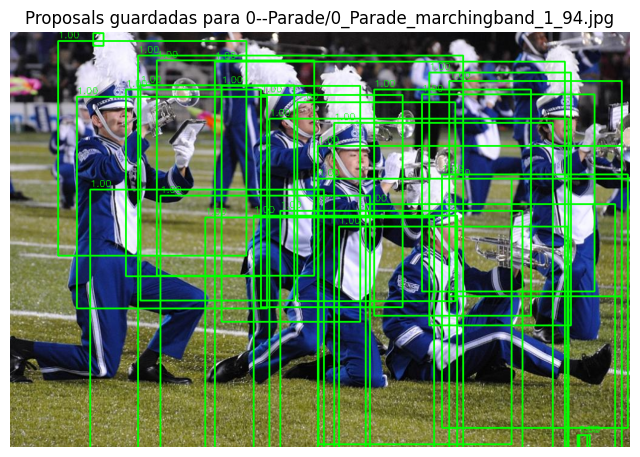

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Ruta al archivo .npz en tu Drive
npz_path = "/content/drive/MyDrive/VisionComputacional/rnet_proposals/0--Parade__0_Parade_marchingband_1_94.jpg.npz"

# Cargar datos
data = np.load(npz_path)
boxes = data["boxes"]       # array de cajas [x1, y1, x2, y2]
scores = data["scores"]     # array de scores
rel_path = str(data["rel_path"])  # ruta relativa de la imagen original

# Cantidad de cajas
print("Número de cajas guardadas (post-NMS):", len(boxes))
print("Número de scores:", len(scores))

# Ruta absoluta a la imagen original
DATASET_ROOT = Path("/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/train")
img_path = DATASET_ROOT / rel_path

# Cargar imagen
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Dibujar cajas (ejemplo: top 30 por score)
topN = min(30, len(boxes))
idxs = np.argsort(scores)[-topN:]

for (x1, y1, x2, y2), score in zip(boxes[idxs], scores[idxs]):
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    color = (0, 255, 0) if score > 0.9 else (255, 0, 0)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, f"{score:.2f}", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Mostrar resultado
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.title(f"Proposals guardadas para {rel_path}")
plt.show()



Número de cajas guardadas (post-NMS): 111082
Número de scores: 111082


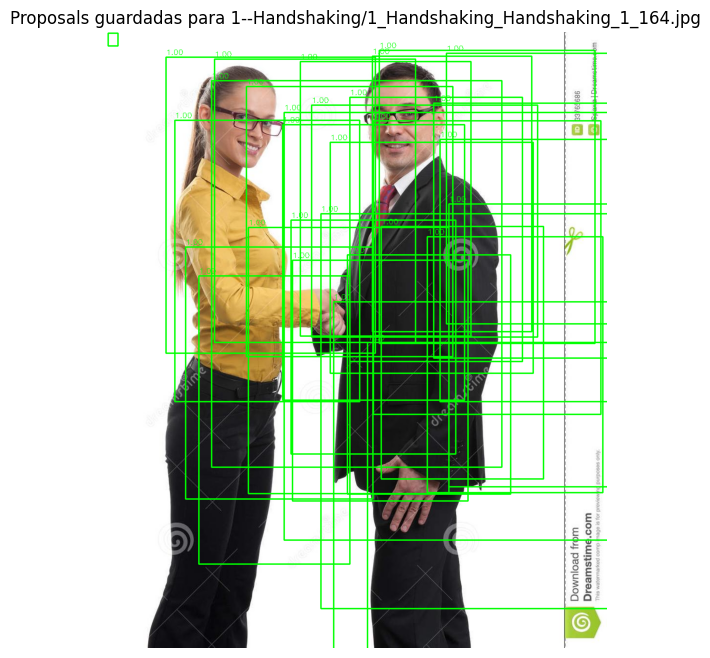

In [ ]:
#1--Handshaking__1_Handshaking_Handshaking_1_164.jpg.npz
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Ruta al archivo .npz en tu Drive
npz_path = "/content/drive/MyDrive/VisionComputacional/rnet_proposals/1--Handshaking__1_Handshaking_Handshaking_1_164.jpg.npz"

# Cargar datos
data = np.load(npz_path)
boxes = data["boxes"]       # array de cajas [x1, y1, x2, y2]
scores = data["scores"]     # array de scores
rel_path = str(data["rel_path"])  # ruta relativa de la imagen original

# Cantidad de cajas
print("Número de cajas guardadas (post-NMS):", len(boxes))
print("Número de scores:", len(scores))

# Ruta absoluta a la imagen original
DATASET_ROOT = Path("/content/drive/MyDrive/VisionComputacional/WIDER_SELECTED/train")
img_path = DATASET_ROOT / rel_path

# Cargar imagen
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Dibujar cajas (ejemplo: top 30 por score)
topN = min(30, len(boxes))
idxs = np.argsort(scores)[-topN:]

for (x1, y1, x2, y2), score in zip(boxes[idxs], scores[idxs]):
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    color = (0, 255, 0) if score > 0.9 else (255, 0, 0)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, f"{score:.2f}", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Mostrar resultado
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.title(f"Proposals guardadas para {rel_path}")
plt.show()



In [ ]:
#PARA OBTENER LOS VALORES DE IoU
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def xywh_to_xyxy(box):
    x, y, w, h = box
    return [x, y, x + w, y + h]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - interArea
    if union == 0:
        return 0.0

    return interArea / union



In [ ]:
NPZ_DIR = Path("/content/drive/MyDrive/VisionComputacional/rnet_proposals")
npz_files = list(NPZ_DIR.glob("*.npz"))

reductions = []

for f in npz_files:
    data = np.load(f, allow_pickle=True)
    boxes = data["boxes"]

    before = len(boxes)
    after = len(boxes)   # ya están después de NMS

    reductions.append(after)

print("Total imágenes analizadas:", len(reductions))



Total imágenes analizadas: 10


In [ ]:
def recover_rel_path(npz_file, annotations):
    """
    Recupera la ruta relativa correcta para buscar en annotations,
    soportando npz antiguos y nuevos.
    """
    name = npz_file.stem  # sin .npz

    # Caso nuevo: ya tiene rel_path
    try:
        data = np.load(npz_file, allow_pickle=True)
        if "rel_path" in data.files:
            return data["rel_path"].item()
    except:
        pass

    # Caso antiguo: Primera parte
    # Ej: 0--Parade__0_Parade_Parade_0_518.jpg
    if "__" in name:
        rel = name.replace("__", "/")
        if not rel.endswith(".jpg"):
            rel += ".jpg"
        return rel

    # Caso MUY antiguo: 0--Parade_0_Parade_Parade_0_109
    # Solución: buscar coincidencia por sufijo
    for k in annotations.keys():
        if k.replace("/", "_").replace(".jpg", "") == name:
            return k

    raise KeyError(f"No se pudo reconstruir rel_path para {name}")


In [ ]:
ious = []
pos = 0
part = 0
neg = 0

for f in npz_files:
    data = np.load(f, allow_pickle=True)
    boxes = data["boxes"]

    # recuperar ruta relativa correcta
    rel = recover_rel_path(f, annotations)

    gt_xywh = annotations[rel]
    gt_box = xywh_to_xyxy(gt_xywh)

    for b in boxes:
        iou = compute_iou(b, gt_box)
        ious.append(iou)

        if iou >= 0.5:
            pos += 1          # rostro claro
        elif iou >= 0.3:
            part += 1         # rostro parcial
        else:
            neg += 1          # fondo


In [ ]:
import pandas as pd
import numpy as np

rows = []

for f in npz_files:
    data = np.load(f, allow_pickle=True)
    num_boxes = len(data["boxes"])

    # recuperar ruta correcta
    rel = recover_rel_path(f, annotations)

    rows.append({
        "imagen": rel,
        "proposals_finales": num_boxes
    })

df = pd.DataFrame(rows)

print(df.head(10))
print("\nResumen estadístico:")
print(df["proposals_finales"].describe())



                                              imagen  proposals_finales
0          0--Parade/0_Parade_marchingband_1_873.jpg             123794
1          0--Parade/0_Parade_marchingband_1_925.jpg             135475
2           0--Parade/0_Parade_marchingband_1_95.jpg              66866
3          0--Parade/0_Parade_marchingband_1_895.jpg              60010
4          0--Parade/0_Parade_marchingband_1_941.jpg              62231
5          0--Parade/0_Parade_marchingband_1_887.jpg              71960
6           0--Parade/0_Parade_marchingband_1_94.jpg              65820
7  1--Handshaking/1_Handshaking_Handshaking_1_409...             116326
8  1--Handshaking/1_Handshaking_Handshaking_1_924...             138268
9  1--Handshaking/1_Handshaking_Handshaking_1_164...             111082

Resumen estadístico:
count        10.000000
mean      95183.200000
std       32531.141797
min       60010.000000
25%       66081.500000
50%       91521.000000
75%      121927.000000
max      138268.000000
Na

In [ ]:
print("========== RESUMEN IoU ==========")
print(f"Total proposals analizadas: {len(ious)}")
print(f"Positives (IoU ≥ 0.5): {pos}")
print(f"Part faces (0.3 ≤ IoU < 0.5): {part}")
print(f"Negatives (IoU < 0.3): {neg}")

print("\nEstadísticas IoU:")
print(f"IoU min: {np.min(ious):.4f}")
print(f"IoU max: {np.max(ious):.4f}")
print(f"IoU mean: {np.mean(ious):.4f}")



========== RESUMEN IoU ==========
Total proposals analizadas: 111082
Positives (IoU ≥ 0.5): 95
Part faces (0.3 ≤ IoU < 0.5): 423
Negatives (IoU < 0.3): 951314

Estadísticas IoU:
IoU min: 0.0000
IoU max: 0.7250
IoU mean: 0.0013


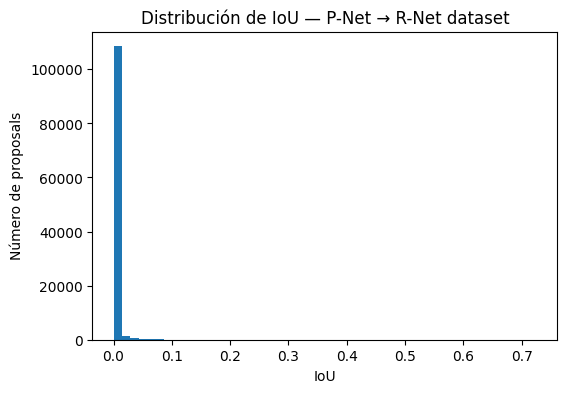

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(ious, bins=50)
plt.xlabel("IoU")
plt.ylabel("Número de proposals")
plt.title("Distribución de IoU — P-Net → R-Net dataset")
plt.show()


“Debido al entrenamiento simplificado de P-Net y al tamaño reducido del dataset, los umbrales de IoU fueron relajados para la generación del dataset de R-Net, manteniendo la estructura del pipeline original de MTCNN.”